In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install librosa torch numpy pandas torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
######### CWD ##############
import os

current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")
if current_dir == "/content":
  os.chdir("drive/My Drive/Colab Notebooks/")
  current_dir = os.getcwd()
  print(f"Current working directory: {current_dir}")

!ls


Current working directory: /content
Current working directory: /content/drive/My Drive/Colab Notebooks
 EC523_HW2_S2025.ipynb	      LJSpeech-1.1.tar.bz2    Untitled0.ipynb
'EC523_HW3_S2025 (1).ipynb'   tacotron2_checkpoints   Untitled1.ipynb
 EC523_HW3_S2025.ipynb	      tacotron2_state_dicts   Untitled2.ipynb
 EC523_project_v4.ipynb       unet.ipynb
 LJSpeech-1.1		      Untitled


In [ ]:
!pip install torch torchvision librosa
import torch
import torchvision
import librosa


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
tacotron2 = torch.hub.load(
    'NVIDIA/DeepLearningExamples:torchhub',
    'nvidia_tacotron2',
    model_math=('fp16' if device.type=='cuda' else 'fp32'),
    # map_location=device,
    pretrained=False
).to(device)


waveglow = torch.hub.load(
    'NVIDIA/DeepLearningExamples:torchhub',
    'nvidia_waveglow',
    model_math=('fp16' if device.type=='cuda' else 'fp32'),
    # map_location=device,
    pretrained=True
).to(device)
import inspect, os


# # 1) Load the utils exactly as before
# utils = torch.hub.load(
#     'NVIDIA/DeepLearningExamples:torchhub',
#     'nvidia_tts_utils'
# )

# # 2) Locate the module where those functions actually live
# mod = inspect.getmodule(utils)
# src_path = mod.__file__                     # "/root/.cache/.../entrypoints.py"

# # 3) Read its source and write it out as a standalone file
# with open(src_path, 'r') as f:
#     src = f.read()
# with open('nvidia_tts_utils.py', 'w') as f:
#     f.write(src)



cuda


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

############ Symbol definitions & mappings ########################
_pad         = '_' #problem
_punctuation = "!\'(),.:;? "
_special     = '-'
_letters     = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
_allowed     = set( _punctuation + _special + _letters)

symbols = list(_pad + _punctuation + _special + _letters)
_symbol_to_id = {s: i for i, s in enumerate(symbols)}
_id_to_symbol = {i: s for s, i in _symbol_to_id.items()}

############ Cleaning & conversion funcs ##########################################
def text_cleaner(text: str) -> str:
    """
    Remove any character not in the allowed set, collapse whitespace.
    """
    cleaned = ''.join(c for c in text if c in _allowed)
    # collapse all whitespace runs to a single space, strip ends
    return ' '.join(cleaned.split())

def text_to_sequence(text: str) -> list[int]:
    """
    Convert a single string into a list of symbol IDs.
    """
    cleaned = text_cleaner(text)
    return [_symbol_to_id[s] for s in cleaned]

def sequence_to_text(sequence: list[int]) -> str:
    """
    Convert a list of symbol IDs back into a string.
    """
    return ''.join(_id_to_symbol[i] for i in sequence)

def prepare_sequence(texts: list[str]):
    """
    Given a batch (list) of strings, return:
      - padded LongTensor of shape (B, T_max)
      - LongTensor of original lengths (B,)
    """
    seq_tensors = []
    lengths = []
    for txt in texts:
        seq = torch.LongTensor(text_to_sequence(txt))
        seq_tensors.append(seq)
        lengths.append(len(seq))

    padded = pad_sequence(
        seq_tensors,
        batch_first=True,
        padding_value=0.0
    )
    return padded, torch.LongTensor(lengths)


In [ ]:
## Test
texts = ["Hello world", "EC523 is sooooo cool"]
padded_ids, seq_lens = prepare_sequence(texts)
print(padded_ids)
print(seq_lens)

tensor([[19, 42, 49, 49, 52, 10, 60, 52, 55, 49, 41,  0,  0,  0,  0,  0,  0],
        [16, 14, 10, 46, 56, 10, 56, 52, 52, 52, 52, 52, 10, 40, 52, 52, 49]])
tensor([11, 17])


In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
print(os.getcwd())
import os
if not os.getcwd()== "/content/drive/My Drive/Colab Notebooks":
  # !ls "drive/My Drive"
  # os.makedirs("/content/drive/My Drive/Colab Notebooks")
  os.chdir(os.path.join("drive/My Drive/Colab Notebooks"))
  print(f"Current directory is now: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [ ]:
import urllib.request, tarfile
import os

data_url = 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'
archive_path = 'LJSpeech-1.1.tar.bz2'
LJSpeech_dir  = 'LJSpeech-1.1'



if not os.path.isdir(LJSpeech_dir):
    print("Downloading LJSpeech-1.1 (~500 MB)...")
    os.makedirs(os.path.join(LJSpeech_dir), exist_ok=True)
    urllib.request.urlretrieve(data_url, archive_path)
    print("Extracting...")
    with tarfile.open(archive_path, 'r:bz2') as tar:
        tar.extractall(path=os.path.dirname(LJSpeech_dir))
    print("Done.")
else:
    print("LJSpeech-1.1 already present.")


LJSpeech-1.1 already present.


In [ ]:
import os
os.getcwd()


'/content/drive/My Drive/Colab Notebooks'

In [ ]:
!ls LJSpeech-1.1

LJSpeech_df.pkl  metadata.csv  README  spectrograms  wavs


In [ ]:
import os
import numpy as np
import librosa
from tqdm import tqdm

lj_dir   = "LJSpeech-1.1"
wav_dir  = os.path.join(lj_dir, "wavs")
npy_dir  = os.path.join(lj_dir, "spectrograms", "numpy")
os.makedirs(npy_dir, exist_ok=True)

# If numpy folder already has files, skip processing
if any(fname.endswith(".npy") for fname in os.listdir(npy_dir)):
    print(f"Already files at {npy_dir}")
else:
    sr          = 22050
    n_fft       = int(0.050 * sr)
    hop_length  = int(0.0125 * sr)
    min_amp     = 0.01

    for fname in tqdm(os.listdir(wav_dir)):
        if not fname.endswith(".wav"):
            continue

        file_id  = os.path.splitext(fname)[0]
        wav_path = os.path.join(wav_dir, fname)
        save_pth = os.path.join(npy_dir, f"{file_id}_mel.npy")

        y, _ = librosa.load(wav_path, sr=sr)

        mel = librosa.feature.melspectrogram(
            y=y, sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=n_fft,
            window='hann',
            power=1.0,
            n_mels=80,
            fmin=125.0,
            fmax=7600.0
        )

        mel = np.clip(mel, a_min=min_amp, a_max=None)
        mel = np.log(mel)

        np.save(save_pth, mel)


Already files at LJSpeech-1.1/spectrograms/numpy


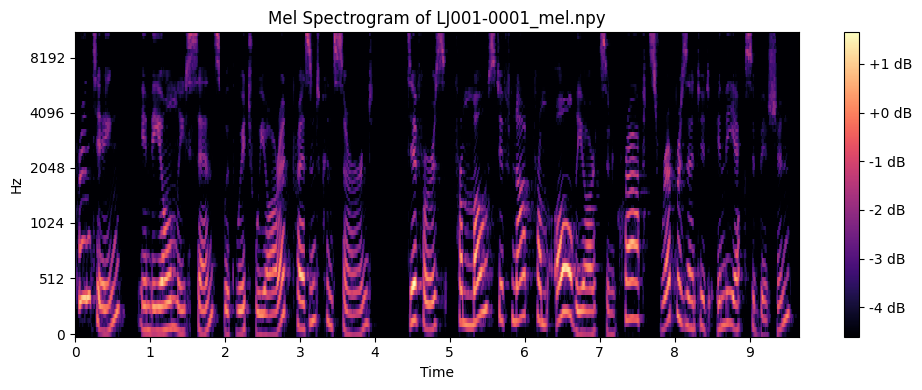

In [ ]:
### Make a spectrogram graph

import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import librosa
import librosa.display

sr = 22050
n_fft = int(0.050 * sr)
hop_length = int(0.0125 * sr)

# Get the first .pt file
files = sorted([f for f in os.listdir(npy_dir) if f.endswith(".npy")])
first_file = files[0]
file_path = os.path.join(npy_dir, first_file)

# Load tensor and convert to numpy
mel_db = np.load(file_path)


# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    mel_db,
    sr=sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="mel"
)
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectrogram of {first_file}")
plt.tight_layout()
plt.show()

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

# paths
if not os.getcwd() == "/content/drive/My Drive/Colab Notebooks":
  try:
    os.chdir("/content/drive/My Drive/Colab Notebooks")
    root = os.getcwd()
    print(f"Current working directory: {root}")
  except:
    root = os.getcwd()
    colab_exists = os.path.exists("/content/drive/My Drive/Colab Notebooks")
    print(f"Current working directory: {root}")
    print(f"The path you're trying to access exists: {colab_exists}")

lj_dir    = "LJSpeech-1.1"
spec_dir  = os.path.join(lj_dir, "spectrograms")
meta_path = os.path.join(lj_dir, "metadata.csv")
wavs_dir  = os.path.join(lj_dir, "wavs")



In [ ]:
!ls ../

 20170713_223902_001.mp4
'2024-08 Roommate Agreement.pdf'
'808th Employer Memo_Siboldi (1).gdoc'
'808th Employer Memo_Siboldi.gdoc'
 annurev-statistics-040620-035329.pdf
 appsheet
 ARN30711-ATP_7-22.02-000-WEB-1.pdf
'B113 Team Building and Conflict Management Advance Sheet(14 JAN 19).pdf'
'Bonfire Questionnaire.gform'
'Check In: Delta Air Lines.pdf'
'Colab Notebooks'
'Copy of Fillable_DriversDataSheet.gdoc'
'Copy of TI Amplifiers - Circuit Cookbook (1).gdoc'
'Copy of TI Amplifiers - Circuit Cookbook.gdoc'
'Drivers Test.gdoc'
 EC523
 Fillable_DriversDataSheet.gdoc
'Fillable_OperatorsLicenseMOU 2 (1).gdoc'
 Fillable_WrittenTest.gdoc
'filled_OperatorsLicenseMOU 2 (1).gdoc'
'FM 6-22 Leader Development.pdf'
'FM 7-0 Train to Win in a Complex World.pdf'
 Hw3.pdf
 IanColemanResumeJuly2023.docx
 IMG_20200627_115253.jpg
 IMG_20220721_105930498.jpg
 IMG_20220808_120818617.jpg
 IMG_20220808_120831619.jpg
'JB edits_BU essay 2023.docx'
'photos for bucket'
'Print ID Card | Aetna Student Health.pdf'
'

In [ ]:
import os
import numpy as np
import pandas as pd

############ paths ################################
lj_dir    = "LJSpeech-1.1"
meta_path = os.path.join(lj_dir, "metadata.csv")
npy_dir   = os.path.join(lj_dir, "spectrograms", "numpy")
os.makedirs(npy_dir, exist_ok=True)


############## load metadata #################################################
meta = pd.read_csv(
    meta_path, sep="|", header=None,
    names=["id","transcript","normalized_transcript"],
    dtype=str
)
print(meta.head())
save_path = os.path.join("LJSpeech-1.1", "LJSpeech_df.pkl")
if os.path.exists(save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df = pd.read_pickle(save_path)
    print(f"Loaded from: {save_path}")
else:
    print("Creating new dataframe")


    # ── build rows ────────────────────────────────────────────────────────────────
    rows = []
    for _, row in meta.iterrows():
        # print(row)
        file_id  = row["id"]
        mel_path = os.path.join(npy_dir, f"{file_id}_mel.npy")
        if not os.path.isfile(mel_path):
            continue

        # 1) load mel (n_mels × T)
        mel     = np.load(mel_path)
        mel_len = mel.shape[1]

        # 2) gate vector: 0 for every frame except final
        gate       = np.zeros(mel_len, dtype=np.float32)
        gate[-1]   = 1.0

        # 3) text → ID sequence
        seq     = text_to_sequence(str(row["normalized_transcript"]))
        seq_len = len(seq)

        rows.append({
            "seq":     seq,
            "seq_len": seq_len,
            "mel":     mel,
            "mel_len": mel_len,
            "gate":    gate
        })

    ############# make DataFrame ##############################
    df = pd.DataFrame(rows, columns=["seq","seq_len","mel","mel_len","gate"])

    # quick check
    print(df[["seq_len","mel_len"]].head())


           id                                         transcript  \
0  LJ001-0001  Printing, in the only sense with which we are ...   
1  LJ001-0002                     in being comparatively modern.   
2  LJ001-0003  For although the Chinese took impressions from...   
3  LJ001-0004  produced the block books, which were the immed...   
4  LJ001-0005  the invention of movable metal letters in the ...   

                               normalized_transcript  
0  Printing, in the only sense with which we are ...  
1                     in being comparatively modern.  
2  For although the Chinese took impressions from...  
3  produced the block books, which were the immed...  
4  the invention of movable metal letters in the ...  
Loaded from: LJSpeech-1.1/LJSpeech_df.pkl


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

# Import your mapping and pad character from your text module
# from your_text_module import _symbol_to_id, _pad  # adjust this import to your code

class LJSpeechDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq     = torch.LongTensor(row['seq'])
        seq_len = torch.LongTensor([row['seq_len']])[0]
        mel     = torch.FloatTensor(row['mel'])       # shape: (n_mels, T)
        mel_len = torch.LongTensor([row['mel_len']])[0]
        gate    = torch.FloatTensor(row['gate'])      # shape: (T,)
        return seq, seq_len, mel, mel_len, gate

def collate_fn(batch):

    MIN_DB = 0.0
    MAX_DB = 80.0
    # Sort batch by seq_len descending
    batch = sorted(batch, key=lambda x: x[1], reverse=True)
    seqs, seq_lens, mels, mel_lens, gates = zip(*batch)

    # Pad sequences (batch_size, T_max)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=_symbol_to_id[_pad])
    seq_lens_tensor = torch.LongTensor(seq_lens)


    # If mels are not normalized, normalize them for training
    mel_Tn = [m.transpose(0,1) for m in mels]
    #    - pad to (batch, T_mel_max, n_mels)
    mels_padded_T = pad_sequence(mel_Tn, batch_first=True, padding_value=MIN_DB)
    #    - back to (batch, n_mels, T_mel_max)
    mels_padded = mels_padded_T.transpose(1,2)

    # 4) normalize into [0,1]
    mels_padded = (mels_padded - MIN_DB) / (MAX_DB - MIN_DB)
    mels_padded = mels_padded.clamp(0.0, 1.0)

    mel_lens_tensor = torch.tensor(mel_lens, dtype=torch.long)

    # Pad gates (batch, T_max)
    gates_padded = pad_sequence(gates, batch_first=True)
    # print(gates_padded.shape)

    return seqs_padded, seq_lens_tensor, mels_padded, gates_padded, mel_lens_tensor

    # return {
    #     'seqs': seqs_padded,
    #     'seq_lens': seq_lens_tensor,
    #     'mels': mels_padded,
    #     'mel_lens': mel_lens_tensor,
    #     'gates': gates_padded
    # }




In [ ]:
# create dataset & dataloader
import torch
import torch.nn as nn

# df = pd.read_pickle("LJSpeech-1.1/LJSpeech_df.pkl")
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

model = tacotron2.to(device)
mse_loss = nn.MSELoss()
bce_loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),
    weight_decay=1e-6
)


# dataset = LJSpeechDataset(df)
# dataloader = DataLoader(
#     dataset,
#     batch_size=32,
#     shuffle=True,
#     collate_fn=collate_fn,
# )


import os
import torch
from torch.utils.data import random_split, DataLoader

# randomized value
seed = 42
generator = torch.Generator().manual_seed(seed)

# Compute split sizes
dataset = LJSpeechDataset(df)
total_size = len(dataset)
train_size = int(0.8 * total_size)
eval_size  = total_size - train_size


train_dataset, eval_dataset = random_split(
    dataset,
    [train_size, eval_size],
    generator=generator
)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,         # shuffle only training
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True
)

eval_loader = DataLoader(
    eval_dataset,
    batch_size=32,
    shuffle=False,        # no need to shuffle validation
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}, Eval batches: {len(eval_loader)}")

num_epochs = 10



Train batches: 328, Eval batches: 82


In [ ]:
from tqdm import tqdm, trange


# model.train()
# def train(model=model, epochs=num_epochs, verbose=True, dataloader=dataloader):
#   for epoch in trange(epochs):
#     print(f"Epoch {epoch}")

# Early stopping parameters
best_loss = float('inf')      # Best loss seen so far
patience = 3                  # How many epochs to wait for improvement
epochs_no_improve = 0         # Counter for epochs with no improvement

debug_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,        # now safe to parallelize
    collate_fn=collate_fn
    # multiprocessing_context="spawn"
)

import time
t0 = time.time()
batch = next(iter(debug_loader))
print("Fetched in", time.time() - t0, "seconds")
print(f"{batch[0].shape}\n{batch[1].shape}\n{batch[2].shape}\n{batch[3].shape}\n{batch[4].shape}\n")
# print(batch["seqs"].shape)
# print(batch["seq_lens"].shape)
# print(batch["mels"].shape)
# print(batch["mel_lens"].shape)
# print(batch["gates"].shape





Fetched in 0.010515689849853516 seconds
torch.Size([16, 168])
torch.Size([16])
torch.Size([16, 80, 798])
torch.Size([16, 798])
torch.Size([16])



In [ ]:
from genericpath import exists
import torch
import numpy as np
import datetime
from tqdm import tqdm, trange
import os
import pandas as pd
import matplotlib.pyplot as plt

def train_tacotron2(
    model,
    train_loader,
    eval_loader,
    optimizer,
    mse_loss,
    bce_loss,
    epochs,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    pretrained=False,
    pretrained_path="tacotorn2_state_dicts/EC523_fixed_gate_2025-05-05_t:0.01_e:0.01.pt",
    sav_dir = "./tacotron2_state_dicts"
):


    """
    """


############## Initialization ##############################

    # move model to device
    model.to(device)

    # load pretrained or initialize
    if pretrained and pretrained_path:
        state = torch.load(os.path.join(pretrained_path), map_location=device)
        model.load_state_dict(state)
        print(f"Loaded pretrained weights from {pretrained_path}")
    else:
        # xavier initialization for Linear, Conv1d, and LSTM layers
        def init_weights(module):
            if isinstance(module, (torch.nn.Linear, torch.nn.Conv1d)):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)
            elif isinstance(module, torch.nn.LSTM):
                for name, param in module.named_parameters():
                    if 'weight_ih' in name or 'weight_hh' in name:
                        torch.nn.init.xavier_uniform_(param)
                    elif 'bias' in name:
                        torch.nn.init.zeros_(param)
        model.apply(init_weights)
        print("Applied Xavier initialization")



    ########### Training Loop ########################

    best_eval_loss = float('inf')
    patience = 3
    epochs_no_improve = 0
    train_losses, eval_losses = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        running_train_loss = 0.0

        # Training loop
        for seqs, seq_lens, mels, gates, mel_lens in tqdm(
            train_loader, desc=f"Train Epoch {epoch}/{epochs}", unit='batch'
        ):

            seqs, seq_lens, mels, gates, mel_lens = [
                x.to(device) for x in (seqs, seq_lens, mels, gates, mel_lens)
            ]
            optimizer.zero_grad()

            # forward pass
            max_seq_len = int(seq_lens.max().item())
            inputs = (seqs, seq_lens, mels, max_seq_len, mel_lens)
            mel_pred_pre, mel_pred_post, gate_pred, _ = model(inputs)

            # Compute losses
            loss = (
                mse_loss(mel_pred_pre, mels) +
                mse_loss(mel_pred_post, mels) +
                bce_loss(gate_pred, gates)
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluation loop
        model.eval()
        running_eval_loss = 0.0
        with torch.no_grad():
            for seqs, seq_lens, mels, gates, mel_lens in eval_loader:
                seqs, seq_lens, mels, gates, mel_lens = [
                    x.to(device) for x in (seqs, seq_lens, mels, gates, mel_lens)
                ]
                max_seq_len = int(seq_lens.max().item())
                inputs = (seqs, seq_lens, mels, max_seq_len, mel_lens)
                mel_pred_pre, mel_pred_post, gate_pred, _ = model(inputs)
                loss = (
                    mse_loss(mel_pred_pre, mels) +
                    mse_loss(mel_pred_post, mels) +
                    bce_loss(gate_pred, gates)
                )
                running_eval_loss += loss.item()

        eval_loss = running_eval_loss / len(eval_loader)
        eval_losses.append(eval_loss)

        # Save checkpoint
        date_str = datetime.date.today().isoformat()
        filename = f"EC523_fg_{date_str}_t:{train_loss:.5f}_e:{eval_loss:.5f}.pt"
        try:
            os.makedirs(sav_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(sav_dir,filename))
            print(f"Epoch {epoch}: train_loss={train_loss:.5f}, eval_loss={eval_loss:.5f}, saved {filename}")
        except:
            print(f"Epoch {epoch}: train_loss={train_loss:.5f}, eval_loss={eval_loss:.5f}")
            print(f"Error saving {filename}")


        try:
          loss_df = pd.DataFrame({"train_loss": train_losses, "eval_loss": eval_losses})  # Create DataFrame
          loss_df.to_pickle(os.path.join(lj_dir, "tacotron2_state_dicts", "for_graph","loss_df.pkl"))
        except:
          print("Error saving loss_df.pkl")

        # Early stopping
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping: no improvement in {patience} epochs.")
                break



    # Convert to numpy arrays
        # train_losses.append(train_losses)
        # eval_losses.append(eval_losses)
        # train_losses_np = np.array(train_losses)
        # eval_losses_np = np.array(eval_losses)
        # loss_df = pd.DataFrame(train_losses_np, eval_losses_np)
        # loss_df.to_pickle(os.path.join(lj_dir, "tacotron2_state_dicts", "for_graph","loss_df.pkl"))
    return train_losses_np, eval_losses_np





In [ ]:
train_losses, eval_losses = train_tacotron2(
    model,
    train_loader=train_loader,
    eval_loader=eval_loader,
    optimizer=optimizer,
    mse_loss=torch.nn.MSELoss(),
    bce_loss=torch.nn.BCEWithLogitsLoss(),
    epochs=20,
    pretrained=False,
    pretrained_path="tacotron2_state_dicts/EC523_2025-05-05_t:0.01_e:0.01.pt",
    sav_dir = "./tacotron2_state_dicts/for_graph"
)
print(f"Train losses: {train_losses}")
print(f"Eval losses: {eval_losses}")


Applied Xavier initialization


Train Epoch 1/20: 100%|██████████| 328/328 [15:40<00:00,  2.87s/batch]


Epoch 1: train_loss=0.54186, eval_loss=0.13622, saved EC523_fg_2025-05-05_t:0.54186_e:0.13622.pt
Error saving loss_df.pkl


Train Epoch 2/20: 100%|██████████| 328/328 [15:39<00:00,  2.87s/batch]


Epoch 2: train_loss=0.21193, eval_loss=0.04986, saved EC523_fg_2025-05-05_t:0.21193_e:0.04986.pt
Error saving loss_df.pkl


Train Epoch 3/20: 100%|██████████| 328/328 [15:40<00:00,  2.87s/batch]


Epoch 3: train_loss=0.07447, eval_loss=0.02045, saved EC523_fg_2025-05-05_t:0.07447_e:0.02045.pt
Error saving loss_df.pkl


Train Epoch 4/20: 100%|██████████| 328/328 [15:40<00:00,  2.87s/batch]


Epoch 4: train_loss=0.02483, eval_loss=0.01051, saved EC523_fg_2025-05-05_t:0.02483_e:0.01051.pt
Error saving loss_df.pkl


Train Epoch 5/20: 100%|██████████| 328/328 [15:40<00:00,  2.87s/batch]


Epoch 5: train_loss=0.01114, eval_loss=0.00835, saved EC523_fg_2025-05-05_t:0.01114_e:0.00835.pt
Error saving loss_df.pkl


Train Epoch 6/20: 100%|██████████| 328/328 [15:39<00:00,  2.86s/batch]


Epoch 6: train_loss=0.00841, eval_loss=0.00804, saved EC523_fg_2025-05-05_t:0.00841_e:0.00804.pt
Error saving loss_df.pkl


Train Epoch 7/20: 100%|██████████| 328/328 [15:39<00:00,  2.86s/batch]


Epoch 7: train_loss=0.00802, eval_loss=0.00797, saved EC523_fg_2025-05-05_t:0.00802_e:0.00797.pt
Error saving loss_df.pkl


Train Epoch 8/20: 100%|██████████| 328/328 [15:40<00:00,  2.87s/batch]


Epoch 8: train_loss=0.00795, eval_loss=0.00800, saved EC523_fg_2025-05-05_t:0.00795_e:0.00800.pt
Error saving loss_df.pkl


Train Epoch 9/20: 100%|██████████| 328/328 [15:37<00:00,  2.86s/batch]


Epoch 9: train_loss=0.00797, eval_loss=0.00793, saved EC523_fg_2025-05-05_t:0.00797_e:0.00793.pt
Error saving loss_df.pkl


Train Epoch 10/20: 100%|██████████| 328/328 [15:41<00:00,  2.87s/batch]


Epoch 10: train_loss=0.00795, eval_loss=0.00798, saved EC523_fg_2025-05-06_t:0.00795_e:0.00798.pt
Error saving loss_df.pkl


Train Epoch 11/20: 100%|██████████| 328/328 [15:39<00:00,  2.86s/batch]


Epoch 11: train_loss=0.00794, eval_loss=0.00794, saved EC523_fg_2025-05-06_t:0.00794_e:0.00794.pt
Error saving loss_df.pkl


Train Epoch 12/20: 100%|██████████| 328/328 [15:38<00:00,  2.86s/batch]


Epoch 12: train_loss=0.00793, eval_loss=0.00791, saved EC523_fg_2025-05-06_t:0.00793_e:0.00791.pt
Error saving loss_df.pkl


Train Epoch 13/20: 100%|██████████| 328/328 [15:39<00:00,  2.86s/batch]


Epoch 13: train_loss=0.00792, eval_loss=0.00787, saved EC523_fg_2025-05-06_t:0.00792_e:0.00787.pt
Error saving loss_df.pkl


Train Epoch 14/20: 100%|██████████| 328/328 [15:40<00:00,  2.87s/batch]


Epoch 14: train_loss=0.00788, eval_loss=0.00779, saved EC523_fg_2025-05-06_t:0.00788_e:0.00779.pt
Error saving loss_df.pkl


Train Epoch 15/20: 100%|██████████| 328/328 [15:40<00:00,  2.87s/batch]


Epoch 15: train_loss=0.00783, eval_loss=0.00776, saved EC523_fg_2025-05-06_t:0.00783_e:0.00776.pt
Error saving loss_df.pkl


Train Epoch 16/20: 100%|██████████| 328/328 [15:39<00:00,  2.86s/batch]


Epoch 16: train_loss=0.00780, eval_loss=0.00778, saved EC523_fg_2025-05-06_t:0.00780_e:0.00778.pt
Error saving loss_df.pkl


Train Epoch 17/20: 100%|██████████| 328/328 [15:37<00:00,  2.86s/batch]


Epoch 17: train_loss=0.00780, eval_loss=0.00786, saved EC523_fg_2025-05-06_t:0.00780_e:0.00786.pt
Error saving loss_df.pkl


Train Epoch 18/20: 100%|██████████| 328/328 [15:38<00:00,  2.86s/batch]


Epoch 18: train_loss=0.00777, eval_loss=0.00796, saved EC523_fg_2025-05-06_t:0.00777_e:0.00796.pt
Error saving loss_df.pkl
Early stopping: no improvement in 3 epochs.


NameError: name 'train_losses_np' is not defined

In [ ]:
#Epoch 1: train_loss=0.54186, eval_loss=0.13622
#Epoch 2: train_loss=0.21193, eval_loss=0.04986
# Epoch 3: train_loss=0.07447, eval_loss=0.02045
# Epoch 4: train_loss=0.02483, eval_loss=0.01051
# Epoch 5: train_loss=0.01114, eval_loss=0.00835
# Epoch 6: train_loss=0.00841, eval_loss=0.00804
# Epoch 7: train_loss=0.00802, eval_loss=0.0079
# Epoch 8: train_loss=0.00795, eval_loss=0.00800
# Epoch 9: train_loss=0.00797, eval_loss=0.00793
# Epoch 10: train_loss=0.00795, eval_loss=0.00798
# Epoch 11: train_loss=0.00794, eval_loss=0.00794
# Epoch 12: train_loss=0.00793, eval_loss=0.00791
# Epoch 13: train_loss=0.00792, eval_loss=0.00787
# Epoch 14: train_loss=0.00788, eval_loss=0.00779
# Epoch 15: train_loss=0.00783, eval_loss=0.00776
# Epoch 16: train_loss=0.00780, eval_loss=0.00778
# Epoch 17: train_loss=0.00780, eval_loss=0.00786
# Epoch 18: train_loss=0.00777, eval_loss=0.00796

#infer a spectrogram
text = "Sasquatch"
model.eval()
a,b = model.infer()

print(a,b)








TypeError: Tacotron2.infer() missing 1 required positional argument: 'input_lengths'

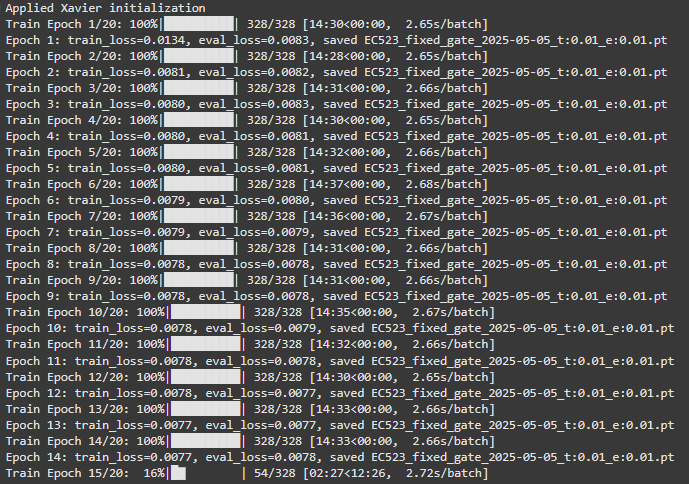

In [ ]:
def infer_tacotron2_and_waveglow(text, tacotron2, waveglow, device, gate_threshold=0.5):
    seq, seq_len = prepare_sequence([text])
    seq, seq_len = seq.to(device), seq_len.to(device)

    tacotron2.eval()
    with torch.no_grad():
        # Adjust input_lengths to ensure it's not shorter than the kernel size
        input_lengths = seq_len.clamp(min=5)  # Ensure at least 5
        mel_post, mel_lens, gate_logits = tacotron2.infer(seq, input_lengths)
        print(f"mel_post: {mel_post.shape}\nmel_lens: {mel_lens.shape}\ngate_logits: {gate_logits.shape}")

        mel = mel_post.squeeze(0)            # now [80, T]
        # if you have a length tensor:
        T_actual = mel_lens.item()          # e.g. 1000
        mel = mel[:, :T_actual]             # trim any padding
        min_db, max_db = -80.0, 0.0
        mel_np = mel.detach().cpu().numpy()          # shape [80, T]
        mel_db = mel_np * (max_db - min_db) + min_db
        mel_db = mel_db[np.newaxis, ...]  # Now shape [1, 80, T]


        # Plot
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            mel_db[0],
            sr=sr,
            hop_length=hop_length,
            x_axis="time",
            y_axis="mel"
        )
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"Mel Spectrogram of inference")
        plt.tight_layout()
        plt.show()

    # gate probabilities
    gate_probs = torch.softmax(gate_logits, dim=1)  # [1, T_out]
    # print(gate_probs)

    stop_idx = torch.argmax(gate_probs)
    # Trim, keep batch dim
    mel_trim = mel_post[:, :, :stop_idx]     # [1, n_mels, T_trim]
    assert mel_trim.dim() == 3


    waveglow.eval()
    with torch.no_grad():
        audio = waveglow.infer(torch.tensor(mel_db,dtype=torch.float32).to(device))    # [1, audio_len]
    return mel_trim[0].cpu(), audio[0].cpu().numpy()

Warning! Reached max decoder steps
mel_post: torch.Size([1, 80, 1000])
mel_lens: torch.Size([1])
gate_logits: torch.Size([1, 1000, 12])


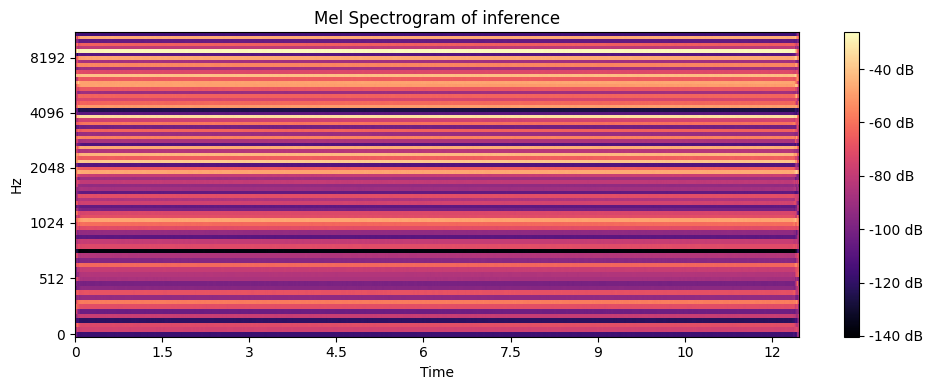

In [ ]:
import torch
from IPython.display import Audio
# ── Usage ─────────────────────────────────────────────────────────────────────
text = "Hello, world"
mel, audio = infer_tacotron2_and_waveglow(text, model, waveglow, device)

# play inline in the notebook
Audio(audio, rate=22050)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa

############# Dataset #####################
class MelWaveDataset(Dataset):
    def __init__(self,
                 file_list,                # list of utterance IDs
                 text_dir,                 # where your normalized .txt files live
                 wav_dir,                  # where your .wav files live
                 mel_predictor,            # your Tacotron2-based mel model
                 text_to_sequence_fn,      # your text→sequence converter
                 hop_length=256,
                 sample_rate=22050):
        self.file_list = file_list
        self.text_dir = text_dir
        self.wav_dir = wav_dir
        self.mel_predictor = mel_predictor.eval()
        self.text_to_sequence = text_to_sequence_fn
        self.hop_length = hop_length
        self.sr = sample_rate

        # freeze Mel predictor
        for p in self.mel_predictor.parameters():
            p.requires_grad = False

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        utt_id = self.file_list[idx]
        # 1) load & preprocess text
        txt = open(os.path.join(self.text_dir, f"{utt_id}.txt")).read().strip()
        seq = self.text_to_sequence(txt)           # e.g. List[int]
        seq = torch.LongTensor(seq).unsqueeze(0)   # [1, L]

        # 2) predict mel
        with torch.no_grad():
            # assume your predictor has a method .infer(seq) → (mel, _, _)
            mel_pred, _, _ = self.mel_predictor.infer(seq)
            # mel_pred: [1, n_mels, T]
        mel_pred = mel_pred.squeeze(0)               # [n_mels, T]

        # 3) load wav
        wav_path = os.path.join(self.wav_dir, f"{utt_id}.wav")
        wav, _ = librosa.load(wav_path, sr=self.sr)
        wav = torch.from_numpy(wav).float()          # [S]

        return mel_pred, wav



In [ ]:
def collate_fn(batch):
    mels, wavs = zip(*batch)
    # pad mels to the max T in batch
    mel_lengths = [m.shape[1] for m in mels]
    mels_padded = nn.utils.rnn.pad_sequence(
        [m.transpose(0,1) for m in mels],  # list of [T, n_mels]
        batch_first=True
    ).transpose(1,2)                      # → [B, n_mels, T_max]

    # crop or pad wav so that wav_len == T_max * hop_length
    hop = 256  # match your Dataset.hop_length
    max_T = mels_padded.size(-1)
    target_wav_len = max_T * hop

    wavs_aligned = []
    for wav, T in zip(wavs, mel_lengths):
        needed = T * hop
        if wav.numel() >= needed:
            wav = wav[:needed]
        else:
            pad = needed - wav.numel()
            wav = nn.functional.pad(wav, (0,pad))
        wavs_aligned.append(wav)
    wavs_padded = nn.utils.rnn.pad_sequence(wavs_aligned,
                                            batch_first=True)  # [B, S_max]
    # add channel dim for WaveGlow: [B, 1, S]
    return mels_padded, wavs_padded.unsqueeze(1)



In [ ]:
# instantiate
file_list = [...]    # e.g. read all IDs from metadata
dataset   = MelWaveDataset(
    file_list=file_list,
    text_dir="path/to/texts",
    wav_dir="path/to/wavs",
    mel_predictor=your_tacotron2_model,
    text_to_sequence_fn=your_text_to_seq_fn,
)

In [ ]:

loader = DataLoader(dataset,
                    batch_size=8,
                    shuffle=True,
                    num_workers=4,
                    collate_fn=collate_fn)

In [ ]:
#################### waveglow ######################
waveglow = torch.hub.load(
    'NVIDIA/DeepLearningExamples:torchhub',
    'nvidia_waveglow',
    pretrained=True
).to(device)
waveglow.train()

In [ ]:
# ############ remove
# print(waveglow)
# # remove weight-norm from all Conv1d layers
# for m in waveglow.modules():
#     if isinstance(m, nn.Conv1d):
#         nn.utils.remove_weight_norm(m)
# print(waveglow)


In [ ]:


def waveglow_loss(z, log_s_list, log_det_W):
    # maximize likelihood:
    #   log p(x|mel) = Σ log s + log det W − ½ ‖z‖²
    batch = z.size(0)
    # sum over all time & channels
    log_s = sum([ls.sum() for ls in log_s_list])
    log_det = log_det_W.sum()
    prior = -0.5 * (z**2).sum()
    log_likelihood = log_s + log_det + prior
    # negative log-likelihood per sample
    return -log_likelihood / batch

# ----------------------------
# 5) Optimizer & training loop
# ----------------------------
optim_wg = optim.Adam(waveglow.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(1, num_epochs+1):
    epoch_loss = 0.0
    for i, (mels, wavs) in enumerate(loader, 1):
        mels = mels.to(device)
        wavs = wavs.to(device)

        optim_wg.zero_grad()
        # forward through flow
        z, log_s_list, log_det_W = waveglow(wavs, mels)
        loss = waveglow_loss(z, log_s_list, log_det_W)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(waveglow.parameters(), 1.0)
        optim_wg.step()

        epoch_loss += loss.item()
        if i % 20 == 0:
            print(f"Epoch {epoch} | step {i}/{len(loader)} | batch loss: {loss.item():.4f}")

    avg = epoch_loss / len(loader)
    print(f"→ Epoch {epoch} finished. avg loss: {avg:.4f}")

    # checkpoint
    ckpt_path = f"waveglow_finetuned_epoch{epoch}.pt"
    torch.save(waveglow.state_dict(), ckpt_path)


In [ ]:
################ Transformer model ##########################
import torch
import torch.nn as nn
import math

# assumes _symbol_to_id and _pad are defined in the notebook
vocab_size   = len(_symbol_to_id)
pad_token_id = _symbol_to_id[_pad]
# pad_sequence

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (seq_len, batch, d_model)
        returns: same shape
        """
        seq_len = x.size(0)
        x = x + self.pe[:seq_len]
        return self.dropout(x)

class TransformerMel(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int = 512,
        n_heads: int = 8,
        num_layers: int = 6,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        n_mels: int = 80,
    ):
        super().__init__()
        # 1) token embedding + positional encoding
        self.token_emb = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token_id)
        self.pos_enc   = PositionalEncoding(embed_dim, dropout)

        # 2) transformer encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # 3) project encoder outputs to mel bins
        self.proj = nn.Linear(embed_dim, n_mels)

    def forward(self, seq: torch.LongTensor, seq_len: torch.LongTensor):
        """
        seq:     (batch, T_seq)
        seq_len: (batch,) actual lengths (unused here, but could mask)
        returns:
          mel_pred: (batch, n_mels, T_seq)
        """
        # create key_padding_mask: True == pad positions
        key_padding_mask = seq == pad_token_id  # (batch, T_seq)

        # embed tokens → (batch, T_seq, embed_dim)
        x = self.token_emb(seq) * math.sqrt(self.token_emb.embedding_dim)

        # reorder for transformer: → (T_seq, batch, embed_dim)
        x = x.transpose(0, 1)

        # add positional encoding
        x = self.pos_enc(x)

        # transformer encode
        # feeds: src=(T_seq, batch, embed_dim), mask pads
        memory = self.encoder(
            x,
            src_key_padding_mask=key_padding_mask
        )  # (T_seq, batch, embed_dim)

        # back to (batch, T_seq, embed_dim)
        memory = memory.transpose(0, 1)

        # linear projection → (batch, T_seq, n_mels)
        mel = self.proj(memory)

        # final shape (batch, n_mels, T_seq)
        mel = mel.transpose(1, 2)
        return mel

# ── Example instantiation ─────────────────────────────────────────────────────

model = TransformerMel(
    vocab_size=vocab_size,
    embed_dim=512,
    n_heads=8,
    num_layers=6,
    dim_feedforward=2048,
    dropout=0.1,
    n_mels=80
).to(device)

print(model)
